In [ ]:
# ! pip install ImbalancedLearningRegression

In [54]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import optuna
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from joblib import dump, load
from scipy.stats import shapiro
from scipy.stats import ttest_rel
from scipy.stats import levene
import ImbalancedLearningRegression as iblr
import seaborn as sns
from sklearn.model_selection import learning_curve

In [55]:
selected_features = ['seller_id', 'product_like_count_sum', 'price_usd_max',
       'seller_price_mean', 'seller_earning_sum', 'seller_products_sold',
       'seller_community_rank', 'seller_num_followers', 'sold', 'in_stock',
       'avg_product_name_length', 'avg_product_keywords_length',
       'products_listed_to_sold_ratio', 'product_type_most_common_target_enc',
       'brand_name_most_common_target_enc', 'seller_country_target_enc',
       'seller_badge_Expert', 'seller_badge_Trusted',
       'usually_ships_within_most_common_3-5 days',
       'usually_ships_within_most_common_unknown']


In [103]:
# Load training and test sets
X_train = pd.read_csv("X_train.csv")[selected_features]  # Apply selected features
y_train = pd.read_csv("y_train.csv").squeeze()
X_test = pd.read_csv("X_test.csv")[selected_features]   
y_test = pd.read_csv("y_test.csv").squeeze()

In [4]:
# Combine X_train and y_train into a single DataFrame for easier manipulation
train_data = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
train_data.columns = ['seller_pass_rate'] + list(X_train.columns)  # Rename target column for clarity

# Apply random undersampling using iblr
undersampled_data = iblr.random_under(
    data=train_data,
    y='seller_pass_rate',         # Target variable column name
    samp_method='balance',        # Sampling method: 'balance' or 'extreme'
    rel_thres=0.8                 # Relevance threshold to identify underrepresented regions
)

# Separate back into features and target
y_train_undersampled = undersampled_data['seller_pass_rate']
X_train_undersampled = undersampled_data.drop(columns=['seller_pass_rate'])


new_index: 100%|##########| 56578/56578 [00:19<00:00, 2919.67it/s]


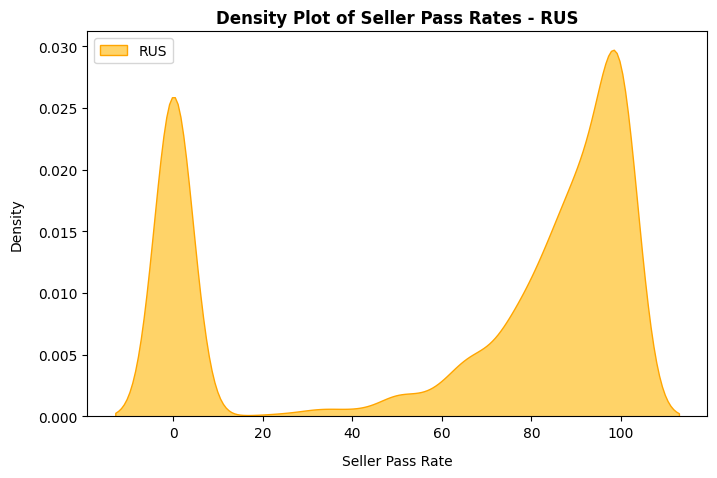

In [151]:
#y_axis_limit = (0, 0.06)  # Adjust based on your data

# Plot the original dataset distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(y_train_undersampled, fill=True, edgecolor='orange', color='#FFB703', label='RUS', alpha=0.6)

# Adjust labels and title for readability
#plt.ylim(y_axis_limit)
plt.xlabel("Seller Pass Rate", labelpad=10)
plt.ylabel("Density", labelpad=10)
#plt.title("Target Variable Density Before RUS", fontsize=16, pad=15)

# Customize ticks for better readability
plt.xticks()
plt.yticks()

# Add a grid for better visual reference
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend with adjusted font size
plt.legend(loc='upper left')
plt.title("Density Plot of Seller Pass Rates - RUS", fontweight='bold')


# Automatically adjust layout for proper spacing
plt.show()

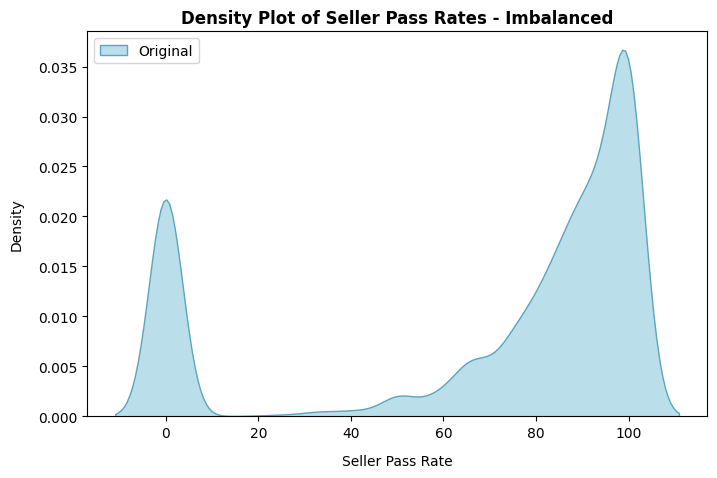

In [152]:
#y_axis_limit = (0, 0.06)  # Adjust based on your data

# Plot the original dataset distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(y_train, fill=True, color='#A9D6E5', edgecolor='#5CA4BF', label='Original', alpha=0.8)

# Adjust labels and title for readability
#plt.ylim(y_axis_limit)
plt.xlabel("Seller Pass Rate", labelpad=10)
plt.ylabel("Density", labelpad=10)
#plt.title("Target Variable Density Before RUS", fontsize=16, pad=15)

# Customize ticks for better readability
plt.xticks()
plt.yticks()

# Add a grid for better visual reference
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend with adjusted font size
plt.legend(loc='upper left')
plt.title("Density Plot of Seller Pass Rates - Imbalanced", fontweight='bold')


# Automatically adjust layout for proper spacing

plt.show()


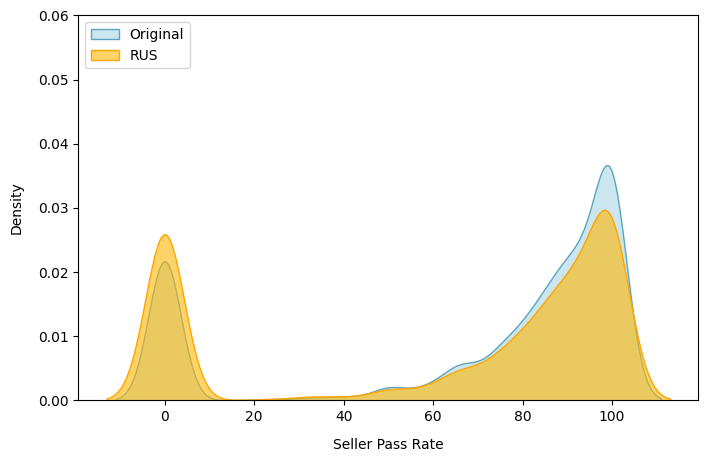

In [156]:
# Plot the original dataset distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(y_train, fill=True, color='#A9D6E5', edgecolor='#5CA4BF', label='Original', alpha=0.6)

# Plot the SMOGN dataset distribution
sns.kdeplot(y_train_undersampled, fill=True, color='#FFB703', edgecolor='orange', label='RUS', alpha=0.6)

# Set consistent scale for the y-axis
plt.ylim(0, 0.06)  # Adjust this value as needed based on your data
plt.xlabel("Seller Pass Rate", labelpad=10)
plt.ylabel("Density", labelpad=10)
#plt.title("Target Variable Density Before and After RUS", fontweight='bold')
plt.legend(loc='upper left')
plt.show()

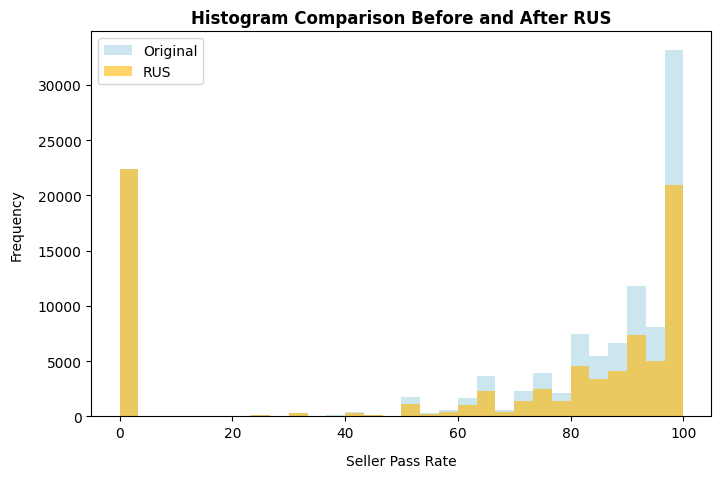

In [154]:
plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=30, alpha=0.6, label="Original", color='#A9D6E5')
plt.hist(y_train_undersampled, bins=30, alpha=0.6, label="RUS", color='#FFB703')
plt.title("Histogram Comparison Before and After RUS", fontweight='bold')
plt.xlabel("Seller Pass Rate", labelpad=10)
plt.ylabel("Frequency", labelpad=10)
plt.legend()
plt.show()

In [11]:
undersampled_data.to_csv('RUS_data.csv', index=False)

In [104]:
undersampled_data = pd.read_csv("RUS_data.csv")

In [105]:
X_train_undersampled = undersampled_data.drop(columns=['seller_pass_rate'])
y_train_undersampled = undersampled_data['seller_pass_rate']

Training Models

In [59]:
# Renamimg X_train_undersampled and y_train_undersampled for consistency
X_train = X_train_undersampled
y_train = y_train_undersampled

1. Linear Regression

In [60]:
metrics = {} 

In [61]:
# Initialize Linear Regression with default parameters
model = LinearRegression()

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation and calculate fold-wise MAE scores
cv_mae = -cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

# Print fold-wise MAE scores
print("Fold-wise MAE scores for Linear Regression:", cv_mae)

# Store fold-wise MAE scores in the metrics dictionary
metrics['Linear Regression'] = cv_mae.tolist()

# Print the metrics dictionary (optional)
print("Updated Metrics Dictionary:", metrics)

# Compute Learning Curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Store learning curve data (convert negative MAE to positive)
learning_curve_data = {
    'train_sizes': train_sizes,
    'train_scores_mean': -train_scores.mean(axis=1),
    'train_scores_std': train_scores.std(axis=1),
    'cv_scores_mean': -cv_scores.mean(axis=1),
    'cv_scores_std': cv_scores.std(axis=1)
}

# Print Learning Curve Data Ready message
print("Learning Curve Data Ready")


Fold-wise MAE scores for Linear Regression: [28.34821226 28.08152226 28.19791084 28.3595019  27.77800403]
Updated Metrics Dictionary: {'Linear Regression': [28.34821225764538, 28.081522259547548, 28.197910836749987, 28.359501898401017, 27.7780040252753]}
Learning Curve Data Ready


In [62]:
final_lr_model = LinearRegression()

# Measure training time
start_time = time.time()
final_lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Save the trained Random Forest Regressor model
lr_imb_path = "lr_imb.pkl"
dump(final_lr_model, lr_imb_path)
print(f"Linear Regression model saved successfully to {lr_imb_path}!")

# Predict on the training set and evaluate
y_train_pred = final_lr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))  
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Results:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R²:", train_r2)
print("Training Time:", training_time, "seconds")

# Predict on the test set and evaluate
start_time = time.time()
y_pred_lr = final_lr_model.predict(X_test)
test_time = time.time() - start_time

pd.DataFrame(y_pred_lr, columns=["y_pred_lr"]).to_csv("lr_rus_predictions.csv", index=False)


test_mae = mean_absolute_error(y_test, y_pred_lr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
test_r2 = r2_score(y_test, y_pred_lr)

print("\nTest Set Results:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R²:", test_r2)
print("Test Evaluation Time:", test_time, "seconds")

Linear Regression model saved successfully to lr_imb.pkl!

Training Set Results:
MAE: 28.094226722501155
RMSE: 33.938884897077564
R²: 0.3259671940887888
Training Time: 0.08640170097351074 seconds

Test Set Results:
MAE: 27.879433715144398
RMSE: 33.977483453504995
R²: 0.17074938603390655
Test Evaluation Time: 0.0065343379974365234 seconds


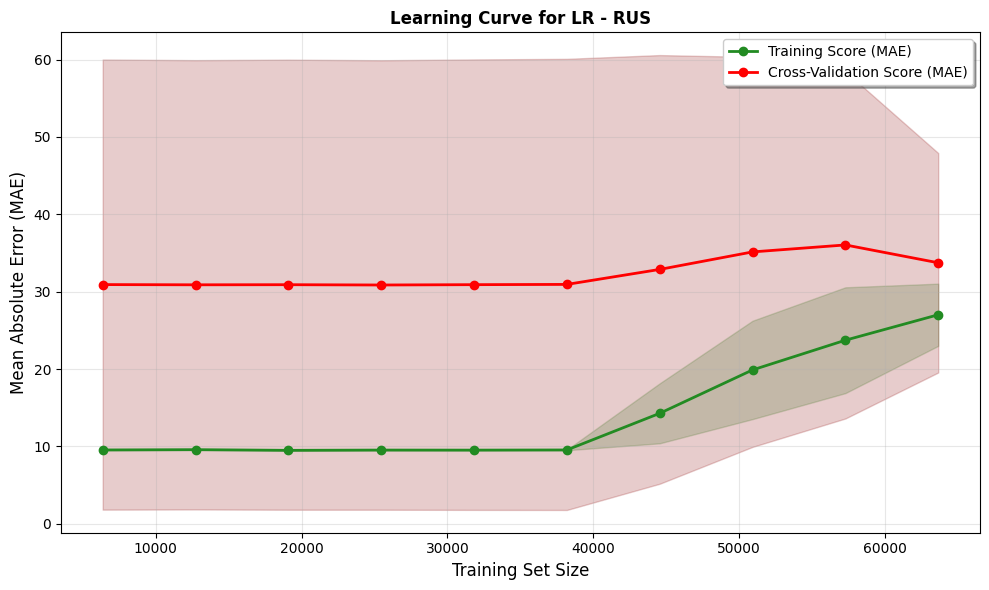

In [63]:
# Plot the learning curve

plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['train_scores_mean'], 
    'o-', color='#228B22', label="Training Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['train_scores_mean'] - learning_curve_data['train_scores_std'],
    learning_curve_data['train_scores_mean'] + learning_curve_data['train_scores_std'],
    alpha=0.2, color='#228B22'
)

# Plot cross-validation scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['cv_scores_mean'], 
    'o-', color='red', label="Cross-Validation Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['cv_scores_mean'] - learning_curve_data['cv_scores_std'],
    learning_curve_data['cv_scores_mean'] + learning_curve_data['cv_scores_std'],
    alpha=0.2, color='#8B0000'
)

# Add labels, title, and legend
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Learning Curve for LR - RUS", fontweight='bold')
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Improve spacing and add a professional touch
plt.tight_layout()
plt.show()



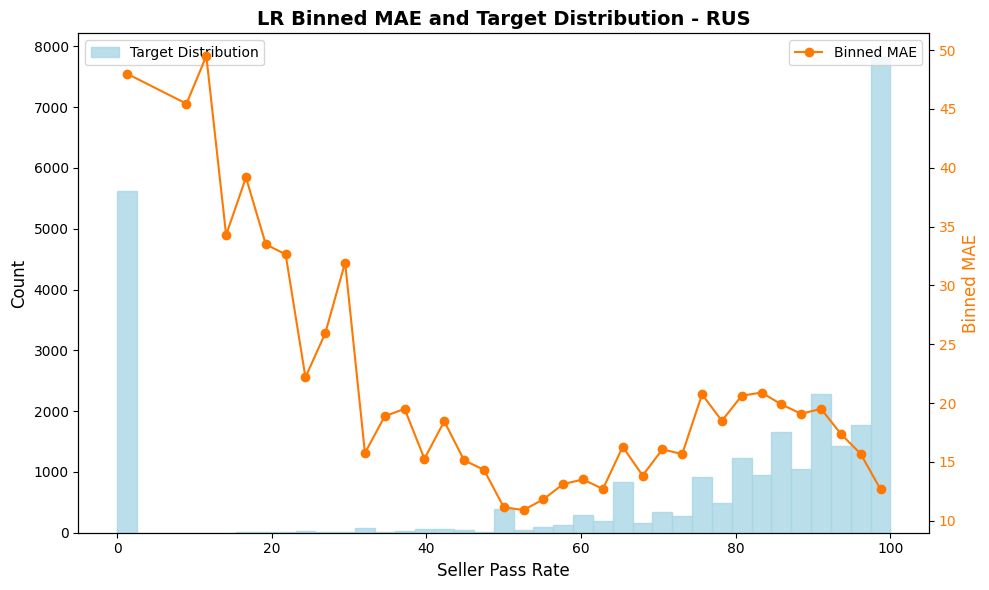

In [64]:
# Target distribution binned MAE for Linear Regression
y_pred = y_pred_lr  # Use predictions from Linear Regression

# Define bins for grouping target values
bins = np.linspace(min(y_test), max(y_test), 40)  # Adjust the number of bins if needed

# Linear Regression Binned MAE Calculation
bin_indices_lr = np.digitize(y_test, bins)  # Create bins for Linear Regression
binned_mae_lr = []
bin_centers_lr = []

for i in range(1, len(bins)):
    mask = bin_indices_lr == i
    if sum(mask) > 0:  # Only calculate MAE for bins with data
        mae = np.mean(np.abs(y_test[mask] - y_pred_lr[mask]))
        binned_mae_lr.append(mae)
        bin_centers_lr.append((bins[i - 1] + bins[i]) / 2)

# Plot Linear Regression Binned MAE
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram for target distribution
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate", fontsize=12)
ax1.set_ylabel("Count", fontsize=12, color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("LR Binned MAE and Target Distribution - RUS", fontsize=14, fontweight="bold")
ax1.legend(loc="upper left", fontsize=10)

# Add secondary y-axis for Binned MAE
ax2 = ax1.twinx()
ax2.plot(bin_centers_lr, binned_mae_lr, color="#FF7800", marker="o", linestyle="-", label="Binned MAE", linewidth=1.5)
ax2.set_ylabel("Binned MAE", fontsize=12, color="#FF7800")
ax2.tick_params(axis="y", labelcolor="#FF7800")
ax2.legend(loc="upper right", fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


2. Gradient Boosting Regressor

In [66]:

# Automatically extract default hyperparameters for Gradient Boosting Regressor
default_model = GradientBoostingRegressor(random_state=42) 
default_params = default_model.get_params() 

# Filter the default hyperparameters to include only the ones being tuned
tuned_params = ['n_estimators', 'max_depth', 'learning_rate']  
filtered_defaults = {key: default_params[key] for key in tuned_params}

# Print the filtered default hyperparameters
print("Default Hyperparameters (Filtered) for Gradient Boosting Regressor:")
for key, value in filtered_defaults.items():
    print(f"{key}: {value}")

# Define the objective function for Bayesian Optimization
def objective(trial):
    # Define hyperparameters to tune (including defaults as ranges)
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)  # Range with step
    max_depth = trial.suggest_int('max_depth', 2, 20, step=2)  # Integer range
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, step=0.01)  # Continuous range

    # Initialize Gradient Boosting Regressor with suggested hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )

    # Define MAE as the scoring metric
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Set up cross-validation with 5 folds and calculate MAE score
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)
    return -cv_mae.mean()  # Return negative MAE for minimization

# Run Optuna Bayesian Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)  # Increase trials for final notebook run

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best Parameters from Bayesian Optimization:", best_params)
print("Best Cross-Validation MAE from Bayesian Optimization:", study.best_value)

# Evaluate the best model and store fold-wise MAE scores
final_model = GradientBoostingRegressor(**best_params, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Collect fold-wise MAE scores
cv_mae = -cross_val_score(final_model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

# Add results to the metrics dictionary
metrics['Gradient Boosting'] = cv_mae.tolist()

# Print fold-wise scores (optional)
print("Fold-wise MAE scores for Gradient Boosting Regressor:", cv_mae)

# Compute Learning Curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Store learning curve data (convert negative MAE to positive)
learning_curve_data = {
    'train_sizes': train_sizes,
    'train_scores_mean': -train_scores.mean(axis=1),
    'train_scores_std': train_scores.std(axis=1),
    'cv_scores_mean': -cv_scores.mean(axis=1),
    'cv_scores_std': cv_scores.std(axis=1)
}

# Print the metrics dictionary to verify
print("Updated Metrics Dictionary:", metrics)
print("Learning Curve Data Ready")


[I 2024-11-28 00:09:18,885] A new study created in memory with name: no-name-d509c4b6-53de-44d3-9d0d-83e6115441b1


Default Hyperparameters (Filtered) for Gradient Boosting Regressor:
n_estimators: 100
max_depth: 3
learning_rate: 0.1


[I 2024-11-28 00:13:57,104] Trial 0 finished with value: 13.44596778481555 and parameters: {'n_estimators': 230, 'max_depth': 8, 'learning_rate': 0.08}. Best is trial 0 with value: 13.44596778481555.
[I 2024-11-28 00:18:08,755] Trial 1 finished with value: 17.662372255536894 and parameters: {'n_estimators': 270, 'max_depth': 6, 'learning_rate': 0.77}. Best is trial 0 with value: 13.44596778481555.
[I 2024-11-28 00:32:21,521] Trial 2 finished with value: 14.610394005328692 and parameters: {'n_estimators': 280, 'max_depth': 20, 'learning_rate': 0.27}. Best is trial 0 with value: 13.44596778481555.
[I 2024-11-28 00:36:59,466] Trial 3 finished with value: 13.44596778481555 and parameters: {'n_estimators': 230, 'max_depth': 8, 'learning_rate': 0.08}. Best is trial 0 with value: 13.44596778481555.
[I 2024-11-28 00:43:58,792] Trial 4 finished with value: 17.723057142100476 and parameters: {'n_estimators': 170, 'max_depth': 16, 'learning_rate': 0.6900000000000001}. Best is trial 0 with value: 

Best Parameters from Bayesian Optimization: {'n_estimators': 210, 'max_depth': 10, 'learning_rate': 0.05}
Best Cross-Validation MAE from Bayesian Optimization: 13.312750070854321
Fold-wise MAE scores for Gradient Boosting Regressor: [13.35126397 13.32836146 13.35845464 13.4355198  13.09015048]
Updated Metrics Dictionary: {'Linear Regression': [28.34821225764538, 28.081522259547548, 28.197910836749987, 28.359501898401017, 27.7780040252753], 'Gradient Boosting': [13.351263967000488, 13.32836145603121, 13.358454643546594, 13.43551980494159, 13.090150482751723]}
Learning Curve Data Ready


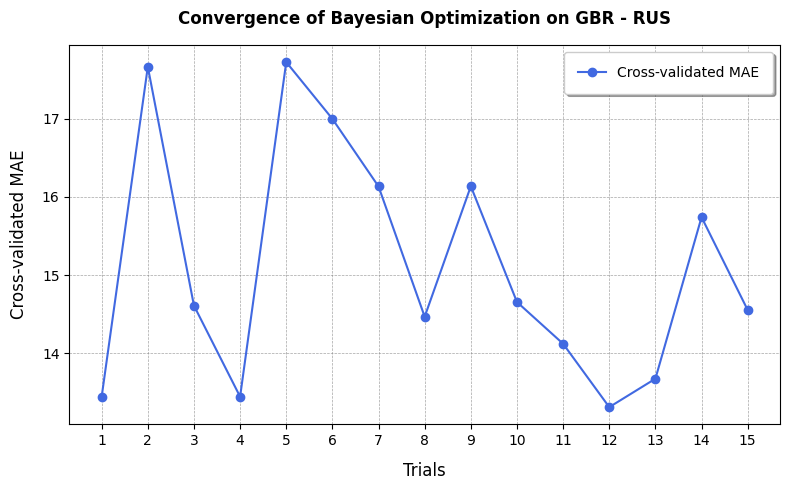

In [67]:
# Convergence Plot 


plt.figure(figsize=(8, 5))  
# Extract data from trials
trials = study.trials_dataframe()
plt.plot(
    trials.index, 
    trials['value'], 
    marker='o', 
    linestyle='-', 
    color='#4169e1',  
    label='Cross-validated MAE'
)

# Adding labels and title
plt.xlabel('Trials', fontsize=12, labelpad=10)  # Add padding for better spacing
plt.ylabel('Cross-validated MAE', fontsize=12, labelpad=10)
plt.title('Convergence of Bayesian Optimization on GBR - RUS', fontsize=12, pad=15, fontweight="bold")

# Ensure Trial Index is displayed as integers
plt.xticks(ticks=range(len(trials)), labels=range(1, len(trials) + 1))  # Trial indices start from 1

# Grid for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend
plt.legend(fontsize=10, loc='best', frameon=True, shadow=True, borderpad=1)

# Improve layout and show the plot
plt.tight_layout()
plt.show()


In [68]:
# Training and Testing with the Best Hyperparameters

best_params = study.best_params

# Initialize Gradient Boosting Regressor with the best parameters
final_gbr_model = GradientBoostingRegressor(**best_params, random_state=42)

# Measure training time
start_time = time.time()
final_gbr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Save the trained Random Forest Regressor model
gbr_imb_path = "gbr_imb.pkl"
dump(final_gbr_model, gbr_imb_path)
print(f"Gradient Boosting model saved successfully to {gbr_imb_path}!")

# Predict on the training set and evaluate
y_train_pred = final_gbr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))  # Root Mean Squared Error
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Results with Best Parameters:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R²:", train_r2)
print("Training Time:", training_time, "seconds")

# Predict on the test set and evaluate
start_time = time.time()
y_pred_gbr = final_gbr_model.predict(X_test)
test_time = time.time() - start_time

pd.DataFrame(y_pred_gbr, columns=["y_pred_gbr"]).to_csv("gbr_rus_predictions.csv", index=False)


test_mae = mean_absolute_error(y_test, y_pred_gbr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
test_r2 = r2_score(y_test, y_pred_gbr)

print("\nTest Set Results with Best Parameters:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R²:", test_r2)
print("Test Evaluation Time:", test_time, "seconds")


Gradient Boosting model saved successfully to gbr_imb.pkl!

Training Set Results with Best Parameters:
MAE: 10.775088417115306
RMSE: 18.42563382564966
R²: 0.8013306965947169
Training Time: 209.3634798526764 seconds

Test Set Results with Best Parameters:
MAE: 14.114070697403195
RMSE: 23.321577915482205
R²: 0.609321740271259
Test Evaluation Time: 0.33246898651123047 seconds


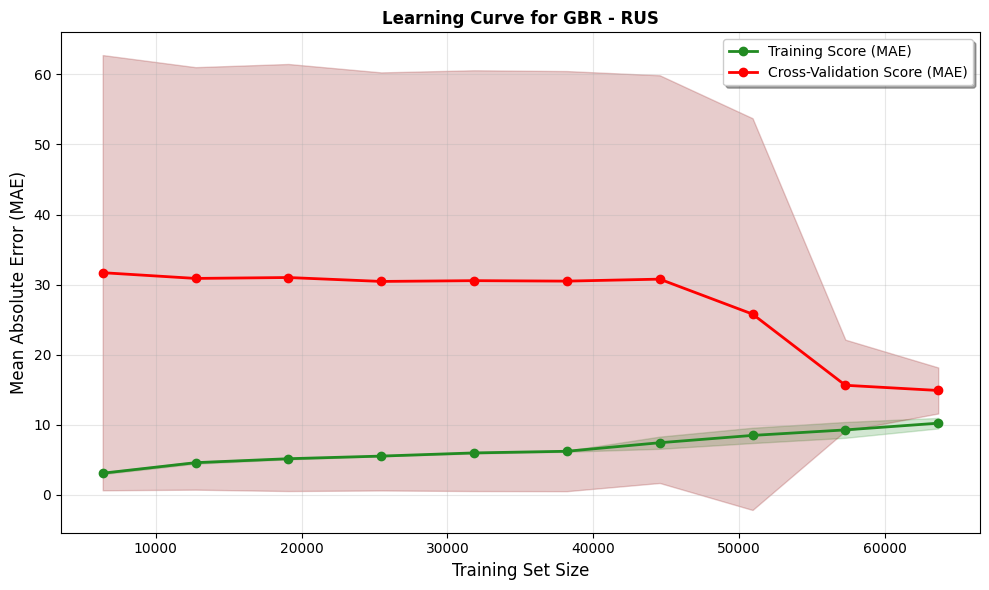

In [69]:
# Plot the learning curve

plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['train_scores_mean'], 
    'o-', color='#228B22', label="Training Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['train_scores_mean'] - learning_curve_data['train_scores_std'],
    learning_curve_data['train_scores_mean'] + learning_curve_data['train_scores_std'],
    alpha=0.2, color='#228B22'
)

# Plot cross-validation scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['cv_scores_mean'], 
    'o-', color='red', label="Cross-Validation Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['cv_scores_mean'] - learning_curve_data['cv_scores_std'],
    learning_curve_data['cv_scores_mean'] + learning_curve_data['cv_scores_std'],
    alpha=0.2, color='#8B0000'
)

# Add labels, title, and legend
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Learning Curve for GBR - RUS", fontweight='bold')
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Improve spacing and add a professional touch
plt.tight_layout()
plt.show()


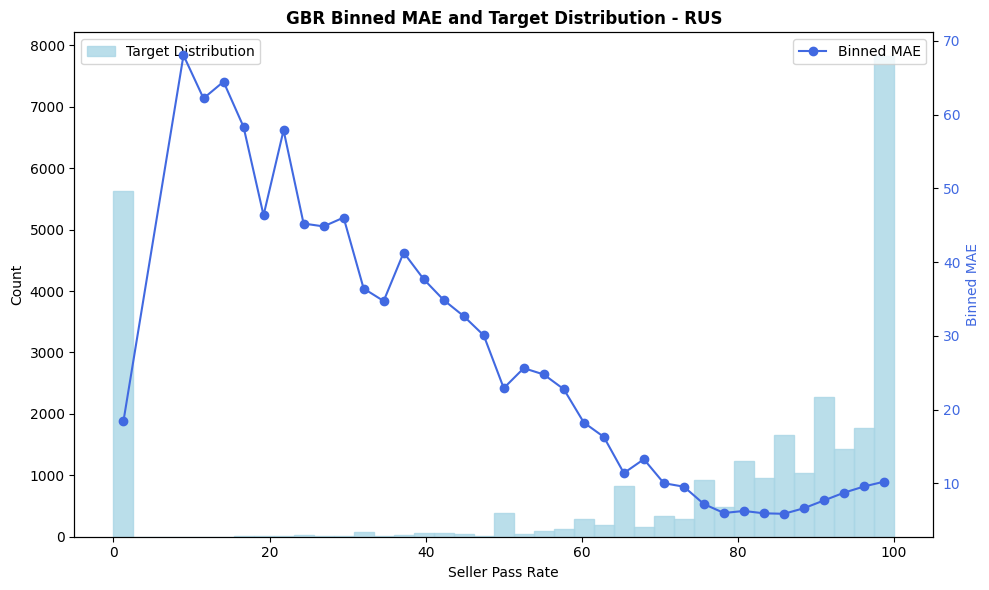

In [70]:
# target distribution binned mae

y_pred = y_pred_gbr 

# Define bins for grouping target values
bins = np.linspace(min(y_test), max(y_test), 40)

# GBR Binned MAE Calculation
bin_indices_gbr = np.digitize(y_test, bins)  # Create bins for GBR
binned_mae_gbr = []
bin_centers_gbr = []

for i in range(1, len(bins)):
    mask = bin_indices_gbr == i
    if sum(mask) > 0:
        mae = np.mean(np.abs(y_test[mask] - y_pred_gbr[mask]))
        binned_mae_gbr.append(mae)
        bin_centers_gbr.append((bins[i - 1] + bins[i]) / 2)

# Plot GBR Binned MAE
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate")
ax1.set_ylabel("Count")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("GBR Binned MAE and Target Distribution - RUS", fontweight="bold")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(bin_centers_gbr, binned_mae_gbr, color="#4169e1", marker="o", linestyle="-", label="Binned MAE")
ax2.set_ylabel("Binned MAE", color="#4169e1")
ax2.tick_params(axis="y", labelcolor="#4169e1")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()   



3. Random Forest Regressor

In [71]:
# Automatically extract default hyperparameters for Random Forest Regressor
default_model = RandomForestRegressor(random_state=42)  
default_params = default_model.get_params()  

# Filter the default hyperparameters to include only the ones being tuned
tuned_params = ['n_estimators', 'max_depth', 'max_features']  
filtered_defaults = {key: default_params[key] for key in tuned_params}

# Print the filtered default hyperparameters
print("Default Hyperparameters (Filtered) for Random Forest Regressor:")
for key, value in filtered_defaults.items():
    print(f"{key}: {value}")

# Define the objective function for Bayesian Optimization
def objective(trial):
    # Define hyperparameters to tune (including defaults as ranges)
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)  # Range with step
    max_depth = trial.suggest_int('max_depth', 2, 20, step=2)  # Integer range
    max_features = trial.suggest_float('max_features', 0.1, 1.0)  # Continuous range

    # Initialize Random Forest Regressor with suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42
    )

    # Define MAE as the scoring metric
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Set up cross-validation with 5 folds and calculate MAE score
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)
    return -cv_mae.mean()  # Return negative MAE for minimization

# Run Optuna Bayesian Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)  # 15 trials

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best Parameters from Bayesian Optimization:", best_params)
print("Best Cross-Validation MAE from Bayesian Optimization:", study.best_value)

# Evaluate the best model and store fold-wise MAE scores
final_model = RandomForestRegressor(**best_params, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Collect fold-wise MAE scores
cv_mae = -cross_val_score(final_model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

# Add results to the metrics dictionary
metrics['Random Forest'] = cv_mae.tolist()

# Print fold-wise scores (optional)
print("Fold-wise MAE scores for Random Forest Regressor:", cv_mae)

# Compute Learning Curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Store learning curve data (convert negative MAE to positive)
learning_curve_data = {
    'train_sizes': train_sizes,
    'train_scores_mean': -train_scores.mean(axis=1),
    'train_scores_std': train_scores.std(axis=1),
    'cv_scores_mean': -cv_scores.mean(axis=1),
    'cv_scores_std': cv_scores.std(axis=1)
}

# Print the metrics dictionary to verify
print("Updated Metrics Dictionary:", metrics)
print("Learning Curve Data Ready")


[I 2024-11-28 02:00:19,219] A new study created in memory with name: no-name-c0af9a1d-636a-4728-b101-0f24ff37e2b8


Default Hyperparameters (Filtered) for Random Forest Regressor:
n_estimators: 100
max_depth: None
max_features: 1.0


[I 2024-11-28 02:00:23,215] Trial 0 finished with value: 28.654707382018625 and parameters: {'n_estimators': 60, 'max_depth': 2, 'max_features': 0.11902131975264928}. Best is trial 0 with value: 28.654707382018625.
[I 2024-11-28 02:00:50,515] Trial 1 finished with value: 15.455583934766912 and parameters: {'n_estimators': 180, 'max_depth': 10, 'max_features': 0.1952637768006355}. Best is trial 1 with value: 15.455583934766912.
[I 2024-11-28 02:01:21,637] Trial 2 finished with value: 13.224832776058145 and parameters: {'n_estimators': 80, 'max_depth': 12, 'max_features': 0.4252495589670011}. Best is trial 2 with value: 13.224832776058145.
[I 2024-11-28 02:01:59,355] Trial 3 finished with value: 14.286013081652097 and parameters: {'n_estimators': 210, 'max_depth': 14, 'max_features': 0.1711322017508685}. Best is trial 2 with value: 13.224832776058145.
[I 2024-11-28 02:02:12,368] Trial 4 finished with value: 23.586964489917396 and parameters: {'n_estimators': 250, 'max_depth': 2, 'max_fea

Best Parameters from Bayesian Optimization: {'n_estimators': 180, 'max_depth': 16, 'max_features': 0.7056676178507237}
Best Cross-Validation MAE from Bayesian Optimization: 13.028357143573363
Fold-wise MAE scores for Random Forest Regressor: [13.03431321 13.07735395 13.11993002 13.12818932 12.78199923]
Updated Metrics Dictionary: {'Linear Regression': [28.34821225764538, 28.081522259547548, 28.197910836749987, 28.359501898401017, 27.7780040252753], 'Gradient Boosting': [13.351263967000488, 13.32836145603121, 13.358454643546594, 13.43551980494159, 13.090150482751723], 'Random Forest': [13.034313207873186, 13.077353946547367, 13.119930018303556, 13.128189315693477, 12.781999229449221]}
Learning Curve Data Ready


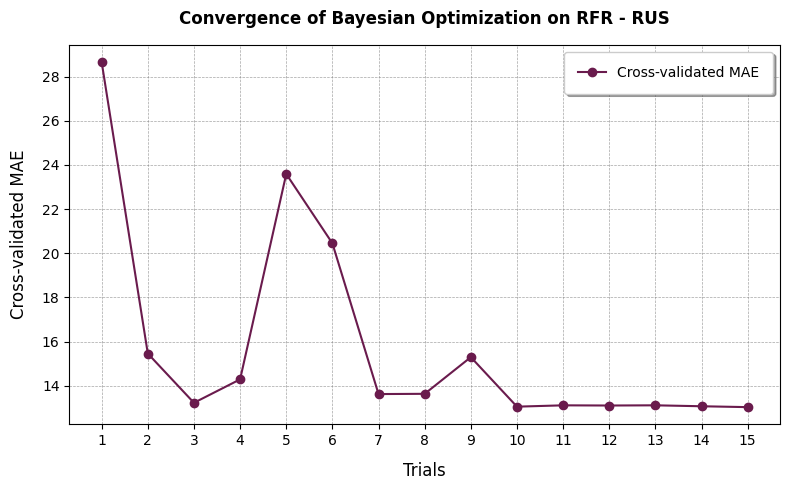

In [72]:
# Convergence Plot 


plt.figure(figsize=(8, 5))  

# Extract data from trials
trials = study.trials_dataframe()
plt.plot(
    trials.index, 
    trials['value'], 
    marker='o', 
    linestyle='-', 
    color='#6A1B4D', #burgundy
    label='Cross-validated MAE'
)

# Adding labels and title
plt.xlabel('Trials', fontsize=12, labelpad=10)  # Add padding for better spacing
plt.ylabel('Cross-validated MAE', fontsize=12, labelpad=10)
plt.title('Convergence of Bayesian Optimization on RFR - RUS', fontsize=12, pad=15, fontweight="bold")

# Ensure Trial Index is displayed as integers
plt.xticks(ticks=range(len(trials)), labels=range(1, len(trials) + 1))  # Trial indices start from 1

# Grid for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend
plt.legend(fontsize=10, loc='best', frameon=True, shadow=True, borderpad=1)

# Improve layout and show the plot
plt.tight_layout()
plt.show()


In [73]:

# Initialize Random Forest Regressor with the best parameters
final_rfr_model = RandomForestRegressor(**best_params, random_state=42)

# Measure training time
start_time = time.time()
final_rfr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Save the trained Random Forest Regressor model
rfr_imb_path = "rfr_imb.pkl"
dump(final_rfr_model, rfr_imb_path)
print(f"Random Forest model saved successfully to {rfr_imb_path}!")

# to load the model (if needed)
# loaded_model = load(model_path)
# print("Model loaded successfully!")

# Predict on the training set and evaluate
y_train_pred = final_rfr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)) 
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Results with Best Parameters:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R²:", train_r2)
print("Training Time:", training_time, "seconds")

# Predict on the test set and evaluate
start_time = time.time()
y_pred_rfr = final_rfr_model.predict(X_test)
test_time = time.time() - start_time

pd.DataFrame(y_pred_rfr, columns=["y_pred_rfr"]).to_csv("rfr_rus_predictions.csv", index=False) #saving rfr predicitons for ttest later

test_mae = mean_absolute_error(y_test, y_pred_rfr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
test_r2 = r2_score(y_test, y_pred_rfr)

print("\nTest Set Results with Best Parameters:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R²:", test_r2)
print("Test Evaluation Time:", test_time, "seconds")


Random Forest model saved successfully to rfr_imb.pkl!

Training Set Results with Best Parameters:
MAE: 11.368389125700086
RMSE: 19.6646738582568
R²: 0.7737131105397794
Training Time: 199.2705261707306 seconds

Test Set Results with Best Parameters:
MAE: 13.83672832344955
RMSE: 23.036119201920332
R²: 0.6188270996291861
Test Evaluation Time: 1.5944108963012695 seconds


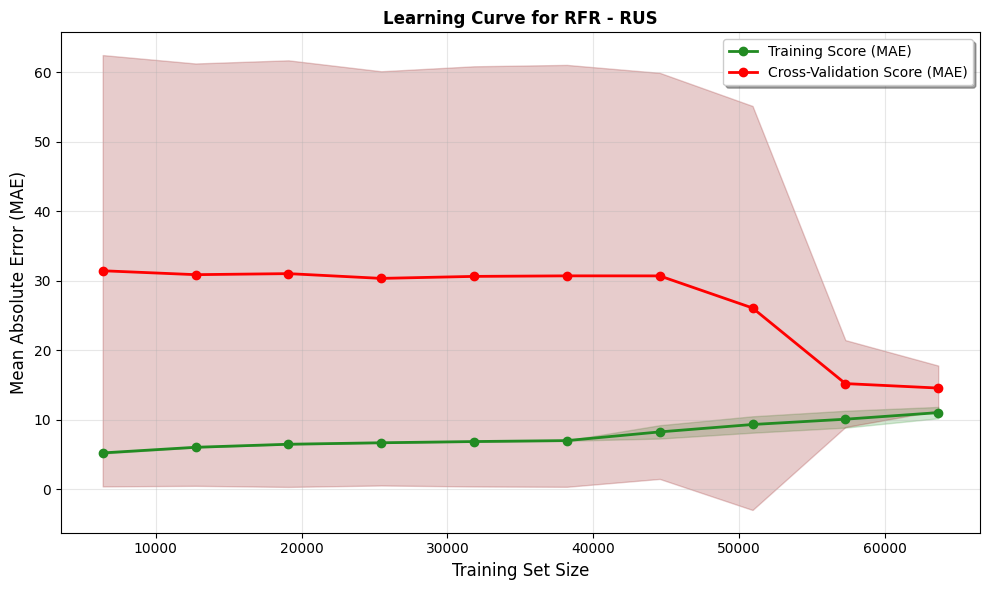

In [74]:
# Plot the learning curve

plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['train_scores_mean'], 
    'o-', color='#228B22', label="Training Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['train_scores_mean'] - learning_curve_data['train_scores_std'],
    learning_curve_data['train_scores_mean'] + learning_curve_data['train_scores_std'],
    alpha=0.2, color='#228B22'
)

# Plot cross-validation scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['cv_scores_mean'], 
    'o-', color='red', label="Cross-Validation Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['cv_scores_mean'] - learning_curve_data['cv_scores_std'],
    learning_curve_data['cv_scores_mean'] + learning_curve_data['cv_scores_std'],
    alpha=0.2, color='#8B0000'
)

# Add labels, title, and legend
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Learning Curve for RFR - RUS", fontweight='bold')
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Improve spacing and add a professional touch
plt.tight_layout()
plt.show()


Binned MAE for GBR: [18.414909481890014, 68.06221076517123, 62.21314527436322, 64.4768580123255, 58.352528302222204, 46.35215068886354, 57.8881891804406, 45.23129105260315, 44.844172697943044, 46.042356750673605, 36.41601841200388, 34.72251216695742, 41.29608310510492, 37.682445769781125, 34.85408546032749, 32.6723404071326, 30.0637350926337, 22.901633190721412, 25.614641606046174, 24.75533769756481, 22.75877368613211, 18.23850454124692, 16.282347752480106, 11.380166516317699, 13.259514317621555, 10.008397242913802, 9.531228659749218, 7.1770004594922945, 5.96331679558131, 6.242980101036744, 5.920524670372879, 5.856048006450058, 6.615170804481125, 7.671351876273195, 8.71923122222164, 9.562845633985186, 10.214050669723122]
Binned MAE for RFR: [18.001412287267595, 67.28001581153126, 65.25275739532934, 63.174045022437646, 60.14565842420749, 47.81740170649706, 55.40251325285991, 45.22421321818189, 46.96258182720392, 44.70723949053296, 36.559381535999236, 34.95718982046662, 40.86653817745535

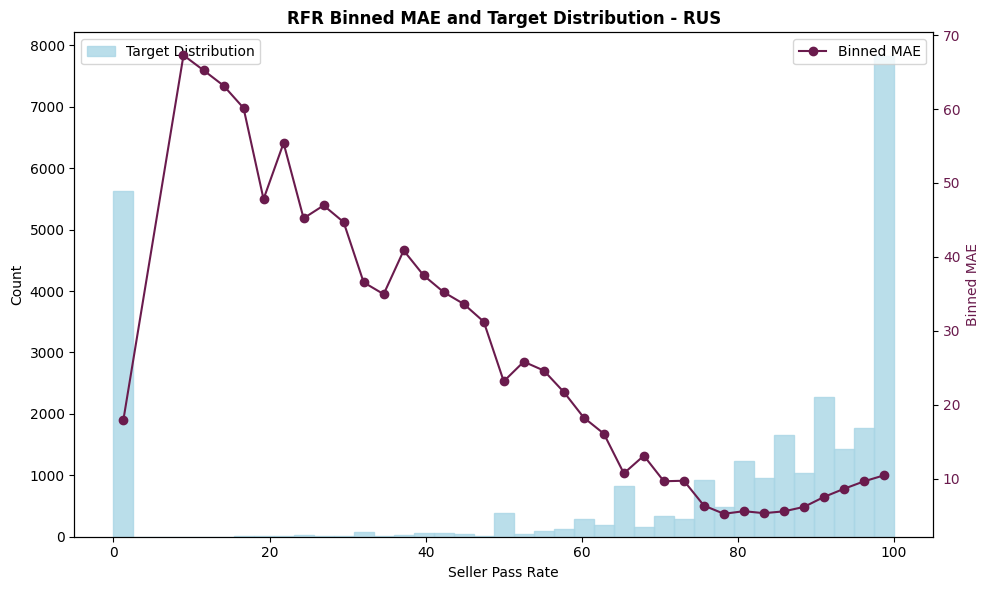

In [75]:
# target distribution binned mae

y_pred = y_pred_rfr 

# RFR Binned MAE Calculation
bin_indices_rfr = np.digitize(y_test, bins)  # Create bins for RFR
binned_mae_rfr = []
bin_centers_rfr = []

for i in range(1, len(bins)):
    mask = bin_indices_rfr == i
    if sum(mask) > 0:
        mae = np.mean(np.abs(y_test[mask] - y_pred_rfr[mask]))
        binned_mae_rfr.append(mae)
        bin_centers_rfr.append((bins[i - 1] + bins[i]) / 2)

# Print to Verify Results
print("Binned MAE for GBR:", binned_mae_gbr)
print("Binned MAE for RFR:", binned_mae_rfr)

# Plot RFR Binned MAE
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate")
ax1.set_ylabel("Count")
ax1.tick_params(axis="y", labelcolor="black", )
ax1.set_title("RFR Binned MAE and Target Distribution - RUS", fontweight="bold")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(bin_centers_rfr, binned_mae_rfr, color="#6A1B4D", marker="o", linestyle="-", label="Binned MAE")
ax2.set_ylabel("Binned MAE", color="#6A1B4D")
ax2.tick_params(axis="y", labelcolor="#6A1B4D")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()



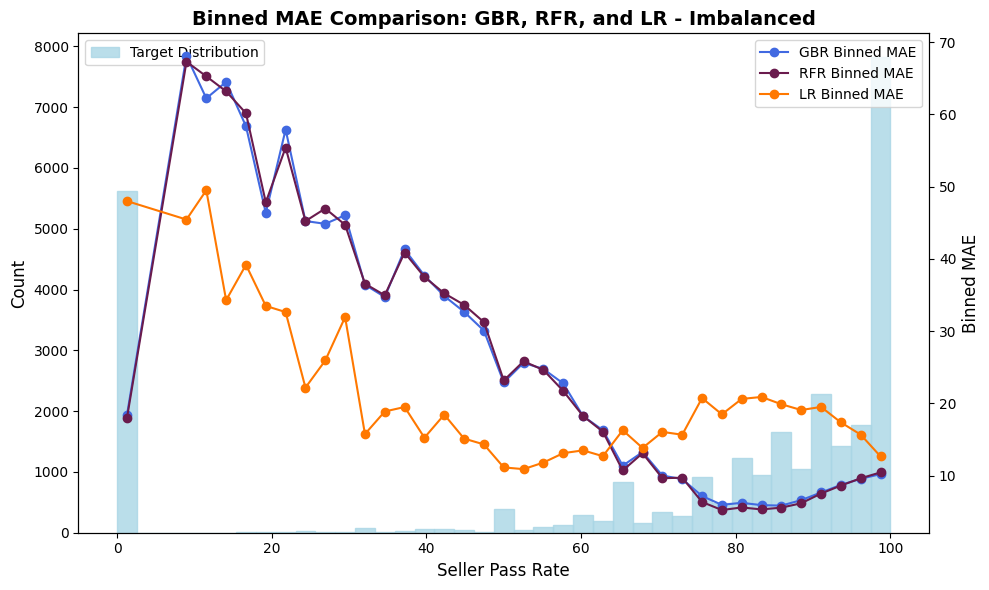

In [76]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram for target distribution
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate", fontsize=12)
ax1.set_ylabel("Count", fontsize=12, color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.legend(loc="upper left", fontsize=10)

# Add secondary y-axis for Binned MAE
ax2 = ax1.twinx()

# Plot GBR Binned MAE
ax2.plot(bin_centers_gbr, binned_mae_gbr, color="#4169e1", marker="o", linestyle="-", label="GBR Binned MAE", linewidth=1.5)

# Plot RFR Binned MAE
ax2.plot(bin_centers_rfr, binned_mae_rfr, color="#6A1B4D", marker="o", linestyle="-", label="RFR Binned MAE", linewidth=1.5)

# Plot LR Binned MAE
ax2.plot(bin_centers_lr, binned_mae_lr, color="#FF7800", marker="o", linestyle="-", label="LR Binned MAE", linewidth=1.5)

# Set secondary y-axis properties
ax2.set_ylabel("Binned MAE", fontsize=12, color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax2.legend(loc="upper right", fontsize=10)

# Title
plt.title("Binned MAE Comparison: GBR, RFR, and LR - Imbalanced", fontsize=14, fontweight="bold")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Feature Importance and Insights

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns 

def plot_feature_importance(model, feature_names, model_name, top_n=10):
    """
    Plots the feature importance for a given model.
    
    Parameters:
    - model: Trained model (GBR or RFR)
    - feature_names: List of feature names
    - model_name: Name of the model (string)
    - top_n: Number of top features to display
    """
    # Extract feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for sorting and visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)
    
      # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=feature_importance_df, 
        x='Importance', 
        y='Feature', 
        color="#01386A", 
        linewidth=1,  # Reduces overall bar size visually
        dodge=False  # Ensures no overlapping
    )
    plt.title(f"Top {top_n} Most Predictive Features: {model_name}", fontweight="bold")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


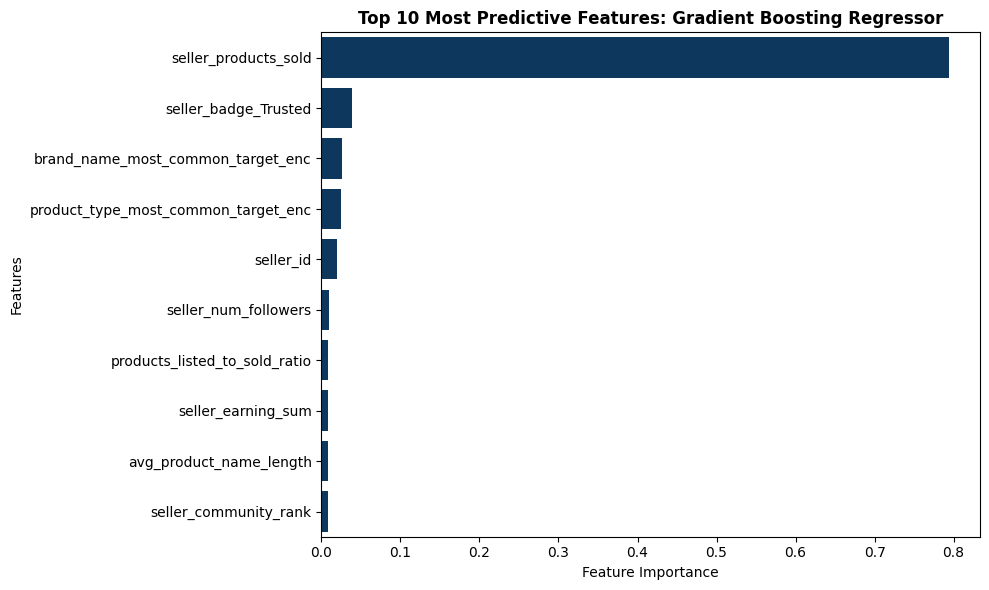

In [81]:
# Plot for GBR
plot_feature_importance(final_gbr_model, X_train.columns, "Gradient Boosting Regressor")

# huge difference. features not predictive? limitation?

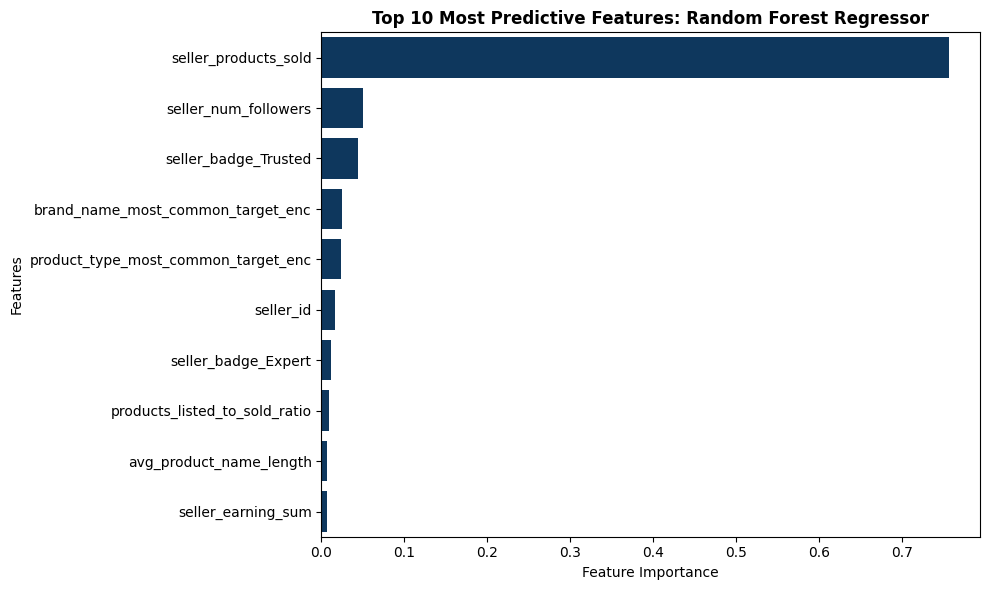

In [82]:
# Plot for RFR
plot_feature_importance(final_rfr_model, X_train.columns, "Random Forest Regressor")

In [83]:
# Load the mapping file
seller_country_mapping = pd.read_csv('seller_country_mapping.csv')

# Ensure y_train is a DataFrame and reset index for alignment
y_train_reset = y_train.reset_index(drop=True)

# Merge mapping back with the encoded dataset
X_train_with_countries = pd.merge(
    X_train[['seller_country_target_enc']].reset_index(drop=True),  # Encoded data with index reset
    seller_country_mapping,  # Mapping file
    on='seller_country_target_enc',
    how='left'  # Match encoded values
)

# Add the target variable back to the merged dataset
X_train_with_countries['seller_pass_rate'] = y_train_reset


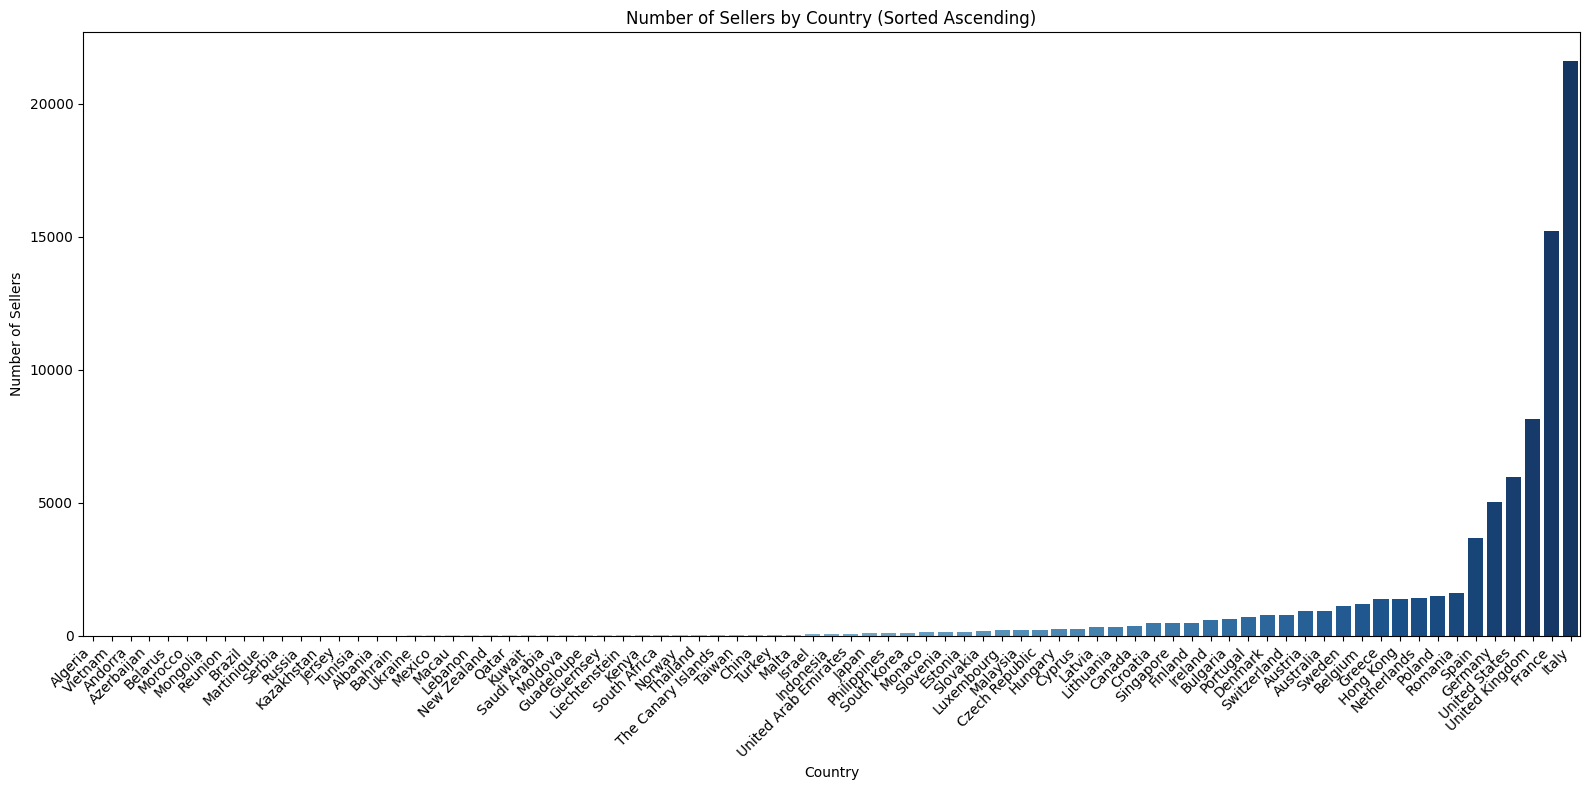

In [85]:
# Group by country names and count the number of sellers
num_sellers_by_country = (
    X_train_with_countries.groupby('seller_country')['seller_pass_rate']
    .count()
    .reset_index()
    .rename(columns={'seller_pass_rate': 'num_sellers'})
)

# Sort by the number of sellers in ascending order
num_sellers_by_country = num_sellers_by_country.sort_values(by='num_sellers', ascending=True)

# Plot the number of sellers per country
plt.figure(figsize=(16, 8))
sns.barplot(
    data=num_sellers_by_country,
    x='seller_country',
    y='num_sellers',
    palette="Blues"
)

plt.title("Number of Sellers by Country (Sorted Ascending)")
plt.xlabel("Country")
plt.ylabel("Number of Sellers")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()



Error Analysis

LR

/var/folders/py/w8w96dx57h53hf_ggjt2zdxh0000gn/T/ipykernel_954/1425208922.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line


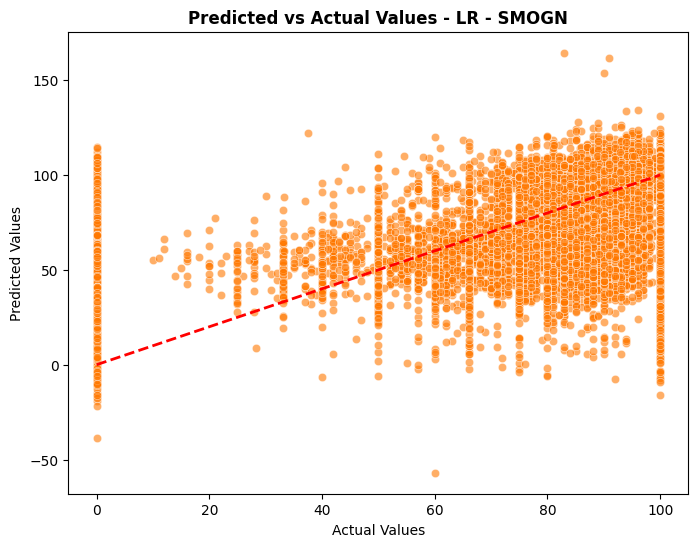

In [92]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6, color='#FF7800')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line
plt.title("Predicted vs Actual Values - LR - SMOGN", fontweight="bold")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


GBR

/var/folders/py/w8w96dx57h53hf_ggjt2zdxh0000gn/T/ipykernel_954/3539725383.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line


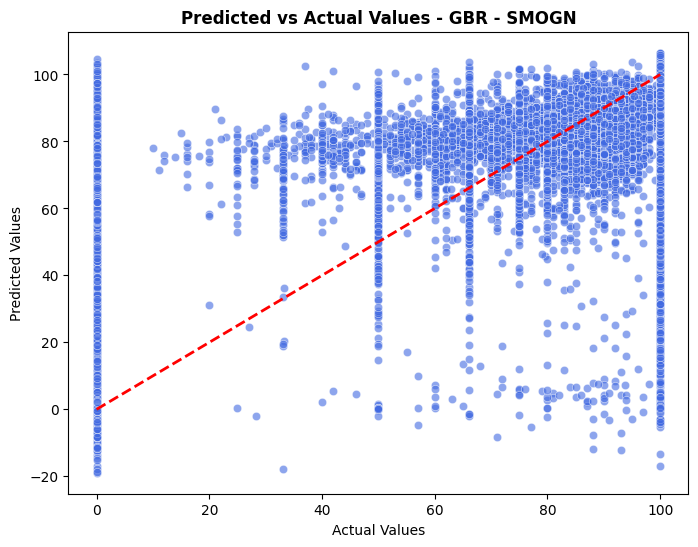

In [93]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_gbr, alpha=0.6, color='#4169e1') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line
plt.title("Predicted vs Actual Values - GBR - SMOGN", fontweight="bold")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

RFR

/var/folders/py/w8w96dx57h53hf_ggjt2zdxh0000gn/T/ipykernel_954/1618858291.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line


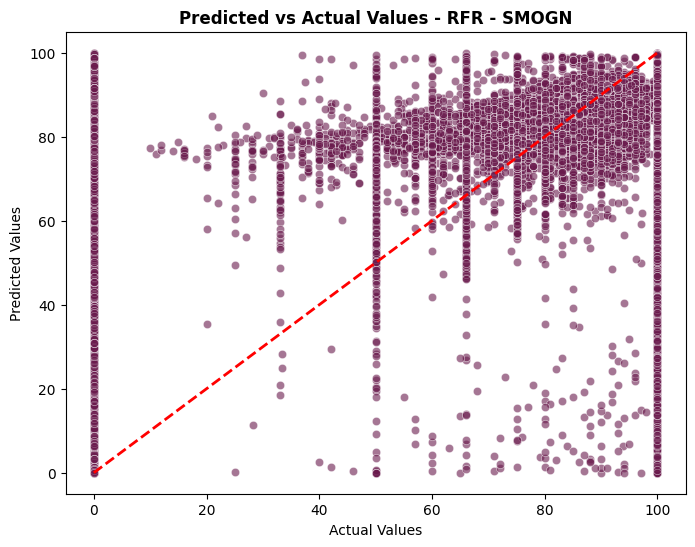

In [94]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rfr, alpha=0.6, color='#6A1B4D')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line
plt.title("Predicted vs Actual Values - RFR - SMOGN", fontweight="bold")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()